In [1]:
import os
import logging
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import yaml
from glob import glob

from src.utils import CosmologySettings, extract_seed_from_path

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
maindir = "/lustre/work/akira.tokiwa/Projects/LensingSSC/"

In [3]:
config_file = os.path.join(maindir, "configs", 'config_analysis.yaml')

# Initialize empty config
config = {}

# Load configuration from YAML if provided and exists
with open(config_file, 'r') as file:
    try:
        config = yaml.safe_load(file)  # Load the configuration from YAML
    except yaml.YAMLError as exc:
        print("Warning: The config file is empty or invalid. Proceeding with default parameters.")
        print(exc)

In [4]:
data_dir = "/lustre/work/akira.tokiwa/Projects/LensingSSC/data/"

cosmo = CosmologySettings(h=0.6774, om=0.309).get_cosmology()
nside = config["nside"]
npix =  hp.nside2npix(nside)
sboxsize = 625
bboxsize = 3750

vmin, vmax = -0.06, 0.06

patch_size = config["patch_size"]
xsize = config["xsize"]
reso = patch_size*60/xsize
nbin = config["nbin"]
lmin, lmax = config["lmin"], config["lmax"]

sl = config["scale_angle"]
ngal = config["ngal"]

bins = np.linspace(-4, 4, nbin+1, endpoint=True)
#l_edges = np.linspace(lmin, lmax, nbin+1, endpoint=True)
l_edges = np.logspace(np.log10(lmin), np.log10(lmax), nbin+1, endpoint=True)

ell = (l_edges[1:] + l_edges[:-1]) / 2
nu = (bins[1:] + bins[:-1]) / 2

In [5]:
def continuous_to_discrete(ell_cont, cl_cont, l_edges):
    ell_idx = np.digitize(ell_cont, l_edges, right=True)
    cl_cont = np.bincount(ell_idx, weights=cl_cont)
    ell_bincount = np.bincount(ell_idx)
    cl_cont = (cl_cont/ell_bincount)[1:]

    return cl_cont

# Load kappa map

In [194]:
kappa_tiled_files = glob(os.path.join(data_dir, "tiled", "*", "smoothed_maps", f'*.fits'))[0]
kappa_bigbox_files = glob(os.path.join(data_dir, "bigbox", "*", "smoothed_maps", f'*.fits'))[0]

In [195]:
kappas_tiled = hp.read_map(kappa_tiled_files)
kappas_bigbox = hp.read_map(kappa_bigbox_files)

2024-09-11 12:12:04,709 - INFO - NSIDE = 8192
2024-09-11 12:12:04,710 - INFO - ORDERING = RING in fits file
2024-09-11 12:12:04,711 - INFO - INDXSCHM = IMPLICIT


2024-09-11 12:12:25,312 - INFO - NSIDE = 8192
2024-09-11 12:12:25,313 - INFO - ORDERING = RING in fits file
2024-09-11 12:12:25,314 - INFO - INDXSCHM = IMPLICIT


In [196]:
seed_tiled = extract_seed_from_path(kappa_tiled_files)
seed_bigbox = extract_seed_from_path(kappa_bigbox_files)

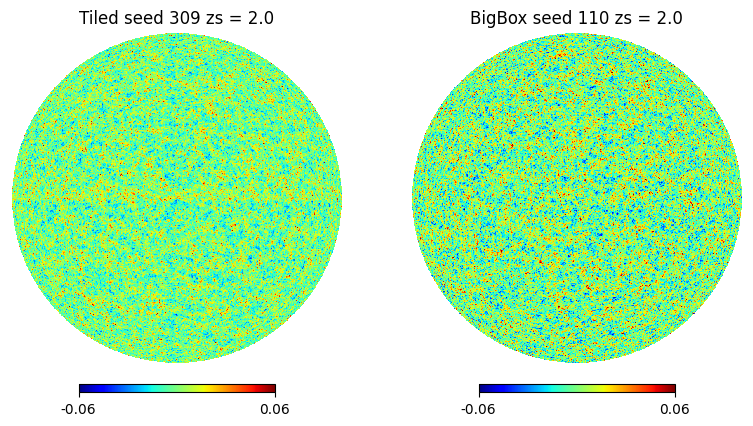

In [198]:
fig = plt.figure(figsize=(8, 4))
title = f"Tiled seed {seed_tiled} zs = {zs}"
hp.orthview(kappas_tiled, fig=fig.number, title=title, sub=(1, 2, 1), cmap="jet", min=vmin, max=vmax, half_sky=True)

title = f"BigBox seed {seed_bigbox} zs = {zs}"
hp.orthview(kappas_bigbox, fig=fig.number, title=title, sub=(1, 2, 2), cmap="jet", min=vmin, max=vmax, half_sky=True)

# Test Analysis

In [151]:
kappas_tiled_dg = hp.ud_grade(kappas_tiled, nside_out=64)
kappas_bigbox_dg = hp.ud_grade(kappas_bigbox, nside_out=64)

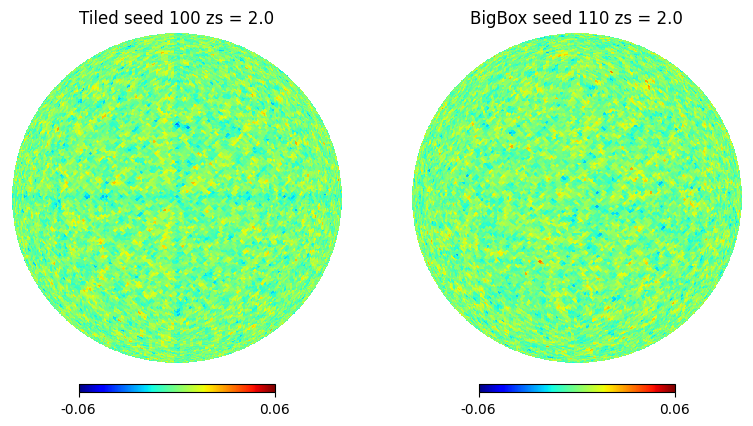

In [152]:
fig = plt.figure(figsize=(8, 4))
title = f"Tiled seed {seed_tiled} zs = {zs}"
hp.orthview(kappas_tiled_dg, fig=fig.number, title=title, sub=(1, 2, 1), cmap="jet", min=vmin, max=vmax, half_sky=True)

title = f"BigBox seed {seed_bigbox} zs = {zs}"
hp.orthview(kappas_bigbox_dg, fig=fig.number, title=title, sub=(1, 2, 2), cmap="jet", min=vmin, max=vmax, half_sky=True)

plt.show()

In [155]:
from src.find_extrema import find_extrema
def perform_analysis(kappa):
    cl = hp.anafast(kappa)
    snr = kappa / np.std(kappa)
    pdf = np.histogram(snr, bins=bins)[0]
    _, peak_amp, _, minima_amp = find_extrema(snr, nside=64)
    peaks = np.histogram(peak_amp, bins=bins)[0]
    minima = np.histogram(minima_amp, bins=bins)[0]

    return cl, pdf, peaks, minima

In [156]:
cl_tiled, pdf_tiled, peaks_tiled, minima_tiled = perform_analysis(kappas_tiled_dg)
cl_bigbox, pdf_bigbox, peaks_bigbox, minima_bigbox = perform_analysis(kappas_bigbox_dg)

Number of peaks identified: 4421
Number of minima identified: 4448
Number of peaks identified: 4403
Number of minima identified: 4436


## Clkk

In [121]:
zs = 2.0

In [134]:
def load_hf(zs):
    hf_file =f"/lustre/work/akira.tokiwa/Projects/LensingSSC/results/halofit/kappa_zs{zs}_Clkk_ell_0_3000.npz"
    hf = np.load(hf_file)
    ell_hf, cl_hf = hf['ell'], hf['clkk']
    cl_dis = continuous_to_discrete(ell_hf, cl_hf, l_edges)
    dl = l_edges[1:] - l_edges[:-1]
    nl = (2 * ell + dl) * dl
    cov_g = cl_dis**2 / nl * 2
    return cl_dis, cov_g

def load_cls(zs):
    cls_files_tiled = glob(os.path.join(data_dir, "cls", "tiled", f"*{zs}*.fits"))
    cls_files_bigbox = glob(os.path.join(data_dir, "cls", "bigbox", f"*{zs}*.fits")) 
    cls_tiled = [hp.read_cl(f) for f in cls_files_tiled]
    cls_bigbox = [hp.read_cl(f) for f in cls_files_bigbox]  

    ell_cont = np.arange(2, lmax + 1)
    cls_tiled = [continuous_to_discrete(ell_cont, cl[1:-1], l_edges) for cl in cls_tiled]
    cls_bigbox = [continuous_to_discrete(ell_cont, cl[1:-1], l_edges) for cl in cls_bigbox]

    mean_cls_tiled = np.mean(cls_tiled, axis=0)
    mean_cls_bigbox = np.mean(cls_bigbox, axis=0)

    diag_cls_tiled = np.diag(np.cov(cls_tiled, rowvar=False))
    diag_cls_bigbox = np.diag(np.cov(cls_bigbox, rowvar=False))

    return mean_cls_tiled, mean_cls_bigbox, diag_cls_tiled, diag_cls_bigbox

In [137]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

def plot_hf_comparison(zs):
    cl_dis, cov_g = load_hf(zs)
    mean_cls_tiled, mean_cls_bigbox, diag_cls_tiled, diag_cls_bigbox = load_cls(zs)

    fig = plt.figure(figsize=(10, 3))

    gs_master = GridSpec(nrows=2, ncols=1, height_ratios=[5, 1], hspace=0.3)
    gs_plot = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_master[0], wspace=0.2)
    gs_ratio = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_master[1], wspace=0.2)
    ax = [fig.add_subplot(gs_plot[i]) for i in range(2)]
    ax_ratio = [fig.add_subplot(gs_ratio[i]) for i in range(2)]

    ax[0].plot(ell, mean_cls_tiled, label="Tiled")
    ax[0].plot(ell, mean_cls_bigbox, label="BigBox")
    ax[0].plot(ell, cl_dis, label="Halofit")
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    #ax[0].set_xlabel(r"$\ell$")
    ax[0].set_ylabel(r"$C_\ell$")
    ax[0].set_xticks([300, 500, 1000, 2000, 3000])
    ax[0].set_xticklabels(["300", "500", "1000", "2000", "3000"])
    ax[0].legend()

    ax_ratio[0].plot(ell, mean_cls_tiled/cl_dis, label="Tiled")
    ax_ratio[0].plot(ell, mean_cls_bigbox/cl_dis, label="BigBox")
    ax_ratio[0].set_xscale('log')
    ax_ratio[0].set_xlabel(r"$\ell$")
    ax_ratio[0].set_ylabel(r"$C_\ell/C_{\ell, HF}$")
    ax_ratio[0].set_xticks([300, 500, 1000, 2000, 3000])
    ax_ratio[0].set_xticklabels(["300", "500", "1000", "2000", "3000"])

    ax[1].plot(ell, diag_cls_tiled, label="Tiled")
    ax[1].plot(ell, diag_cls_bigbox, label="BigBox")
    ax[1].plot(ell, cov_g, label="Halofit")
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    #ax[1].set_xlabel(r"$\ell$")
    ax[1].set_ylabel(r"$Cov(C_\ell, C_{\ell})$")
    ax[1].set_xticks([300, 500, 1000, 2000, 3000])
    ax[1].set_xticklabels(["300", "500", "1000", "2000", "3000"])
    ax[1].legend()

    ax_ratio[1].plot(ell, diag_cls_tiled/cov_g, label="Tiled")
    ax_ratio[1].plot(ell, diag_cls_bigbox/cov_g, label="BigBox")
    ax_ratio[1].set_xscale('log')
    ax_ratio[1].set_xlabel(r"$\ell$")
    ax_ratio[1].set_ylabel(r"$Cov(C_\ell, C_{\ell}) / C_{\ell, HF}^2 \times N_{\ell} / 2$")
    ax_ratio[1].set_xticks([300, 500, 1000, 2000, 3000])
    ax_ratio[1].set_xticklabels(["300", "500", "1000", "2000", "3000"])
    
    plt.show()

In [140]:
ratios_tiled = []
ratios_bigbox = []

for zs in [2.0, 1.0, 0.5]:
    cl_dis, cov_g = load_hf(zs)
    mean_cls_tiled, mean_cls_bigbox, diag_cls_tiled, diag_cls_bigbox = load_cls(zs)
    ratios_tiled.append(diag_cls_tiled / cov_g)
    ratios_bigbox.append(diag_cls_bigbox / cov_g)

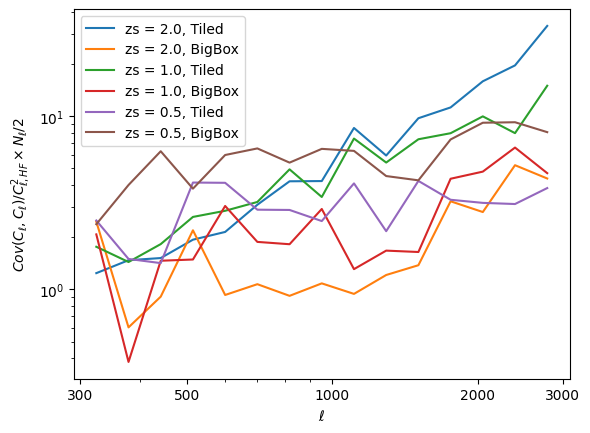

In [145]:
for i, zs in enumerate([2.0, 1.0, 0.5]):
    plt.plot(ell, ratios_tiled[i], label=f"zs = {zs}, Tiled")
    plt.plot(ell, ratios_bigbox[i], label=f"zs = {zs}, BigBox")

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\ell$")
plt.ylabel(r"$Cov(C_\ell, C_{\ell}) / C_{\ell, HF}^2 \times N_{\ell} / 2$")
plt.xticks([300, 500, 1000, 2000, 3000], ["300", "500", "1000", "2000", "3000"])
plt.legend()

plt.show()


zs = 2.0


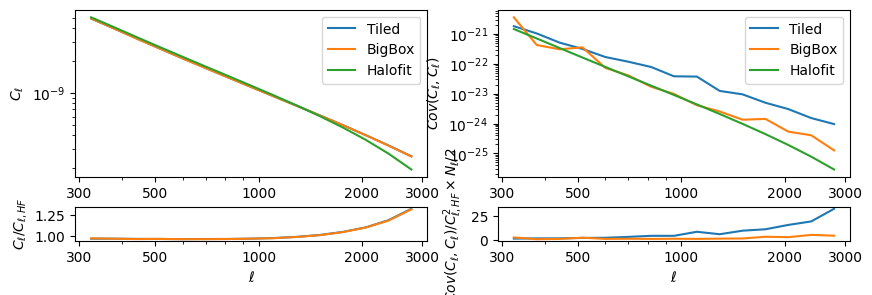

zs = 1.0


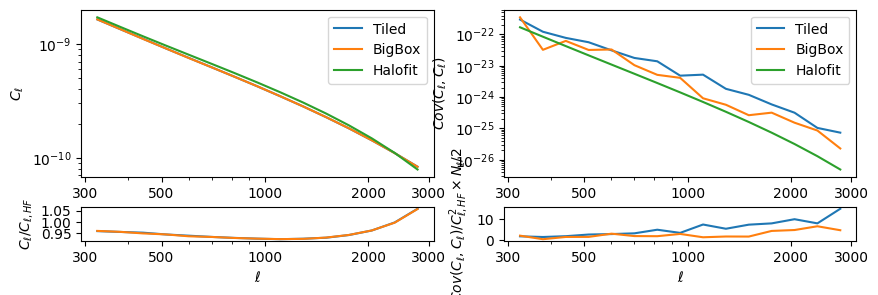

zs = 0.5


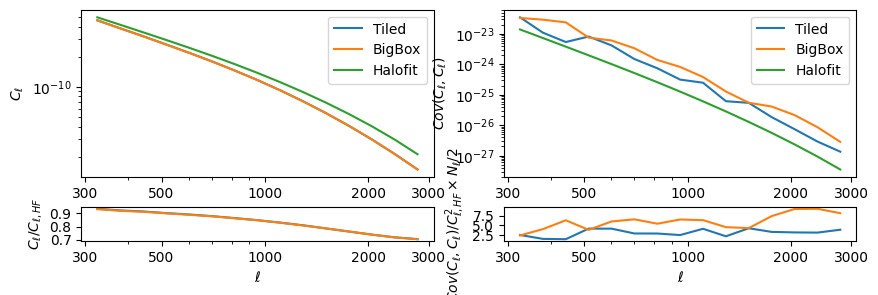

In [139]:
for zs in [2.0, 1.0, 0.5]:
    print(f"zs = {zs}")
    plot_hf_comparison(zs)

# Read the results

In [6]:
def normalize_peak(peak):
    return (peak.T/np.sum(peak, axis=1)).T

def dimensionless_cl(cl, ell):
    return ell * (ell+1) * cl / (2*np.pi)

def dimiensionless_bispectrum(bispec, ell):
    return bispec * ell**4 / (2*np.pi)**2

In [7]:
def gen_suffix(zs, scale_angle=2, noiseless=True, ngal=30):
    suffix = f"zs{zs:.1f}_sl{scale_angle}"
    if noiseless:
        suffix += "_noiseless"
    else:
        suffix += f"_ngal{ngal}"

    return suffix

def safe_load(path):
    try:
        return np.load(path, allow_pickle=True)
    except Exception as e:
        print(f"Error loading file {i}: {path}. Skipping. Error: {e}")
        return None

In [8]:
def stacking_analysis(data_paths):
    data = np.vstack([safe_load(path) for path in data_paths if safe_load(path) is not None])
    diags = np.diag(np.cov(data, rowvar=False))
    corr = np.corrcoef(data, rowvar=False)
    stds = np.std(data, axis=0)
    means = np.mean(data, axis=0)

    return means, stds, diags, corr

In [9]:
from src.plot import plot_corr, plot_stats

In [10]:
hf_file =f"/lustre/work/akira.tokiwa/Projects/LensingSSC/results/halofit/kappa_zs{zs}_Clkk_ell_0_3000.npz"
hf = np.load(hf_file)
ell_hf, cl_hf = hf['ell'], hf['clkk']
cl_dis = continuous_to_discrete(ell_hf, cl_hf, l_edges)

NameError: name 'zs' is not defined

In [12]:
zs=1.0
noiseless = False
ngal = 30
suffix = gen_suffix(zs, scale_angle=sl, noiseless=noiseless, ngal=ngal)    

fullsky_tiled = sorted(glob(os.path.join(data_dir, "fullsky" ,"tiled", f'*_{suffix}.npy')))
fullsky_bigbox = sorted(glob(os.path.join(data_dir,"fullsky" ,"bigbox", f'*_{suffix}.npy')))

print("Found {} full sky maps for tiled and {} for bigbox".format(len(fullsky_tiled), len(fullsky_bigbox)))

Found 20 full sky maps for tiled and 10 for bigbox


In [346]:
data_tiled = [safe_load(path) for path in fullsky_tiled if safe_load(path) is not None]
data_bigbox = [safe_load(path) for path in fullsky_bigbox if safe_load(path) is not None]

In [347]:
means_tiled, stds_tiled, diags_tiled, corr_tiled = stacking_analysis(fullsky_tiled)
means_bigbox, stds_bigbox, diags_bigbox, corr_bigbox = stacking_analysis(fullsky_bigbox)

Saved: /lustre/work/akira.tokiwa/Projects/LensingSSC//img/fullsky/correlation_zs3.0_sl2_ngal30.png


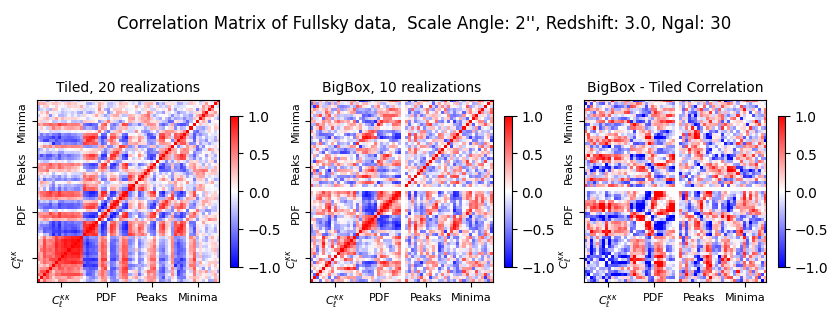

In [348]:
fname = os.path.join(f"{maindir}/img/fullsky", f"correlation_{suffix}.png")
title = f"Correlation Matrix of Fullsky data, "+f" Scale Angle: {sl}"+r"''"+f", Redshift: {zs}"
if noiseless:
    title += ", Noiseless"
else:
    title += f", Ngal: {ngal}"
title_tiled = f"Tiled, {len(data_tiled)} realizations"
title_bigbox = f"BigBox, {len(data_bigbox)} realizations"
labels = [r'$C^{\kappa\kappa}_{\ell}$', "PDF", "Peaks", "Minima"]
plot_corr(fname, corr_tiled, corr_bigbox, title, title_tiled, title_bigbox, labels, vmin=-1, vmax=1)

Saved: /lustre/work/akira.tokiwa/Projects/LensingSSC//img/fullsky/mean_zs3.0_sl2_ngal30.png


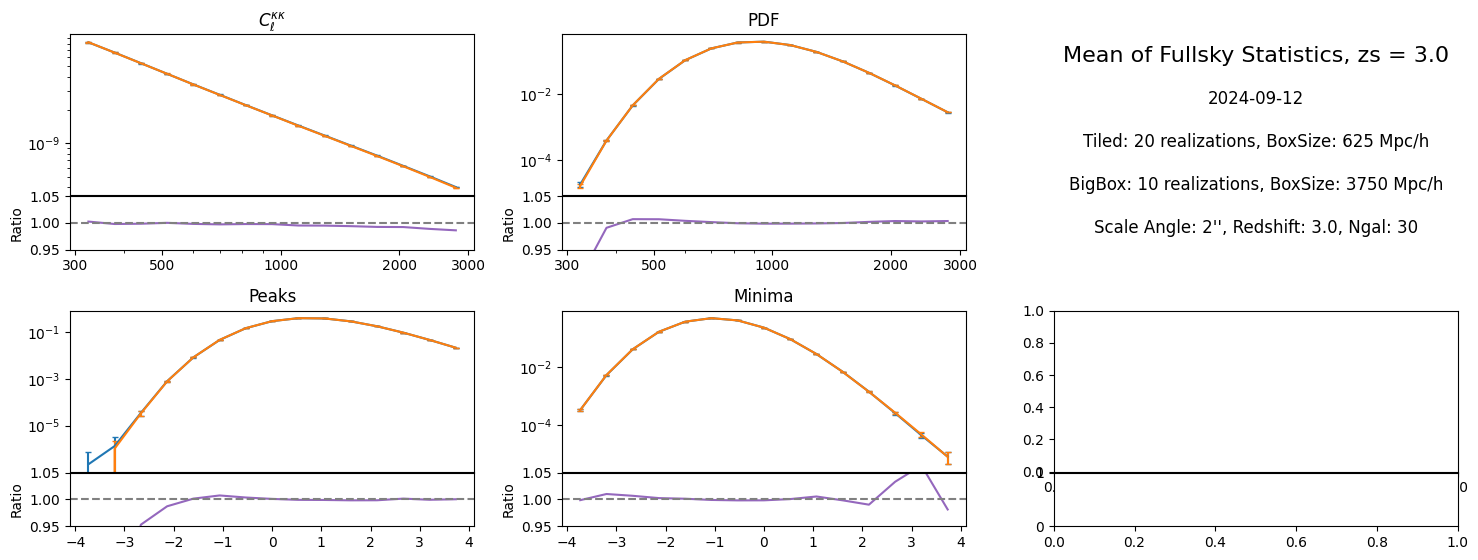

In [349]:
fname = f"{maindir}/img/fullsky/mean_{suffix}.png"
title = f"Mean of Fullsky Statistics, zs = {zs}"
title_tiled = f"Tiled: {len(data_tiled)} realizations, BoxSize: {sboxsize} Mpc/h"
title_bigbox = f"BigBox: {len(data_bigbox)} realizations, BoxSize: {bboxsize} Mpc/h"
title_attrs = f"Scale Angle: {sl}"+r"''"+f", Redshift: {zs}"
if noiseless:
    title_attrs += ", Noiseless"
else:
    title_attrs += f", Ngal: {ngal}"
labels = [r'$C^{\kappa\kappa}_{\ell}$', 
          "PDF",
          "Peaks",
          "Minima"]

plot_stats(fname, title, title_tiled, title_bigbox, title_attrs, ell, nu, means_tiled, means_bigbox, labels, stds_tiled, stds_bigbox)

Saved: /lustre/work/akira.tokiwa/Projects/LensingSSC//img/fullsky/diagonal_zs2.0_sl2_ngal30.png


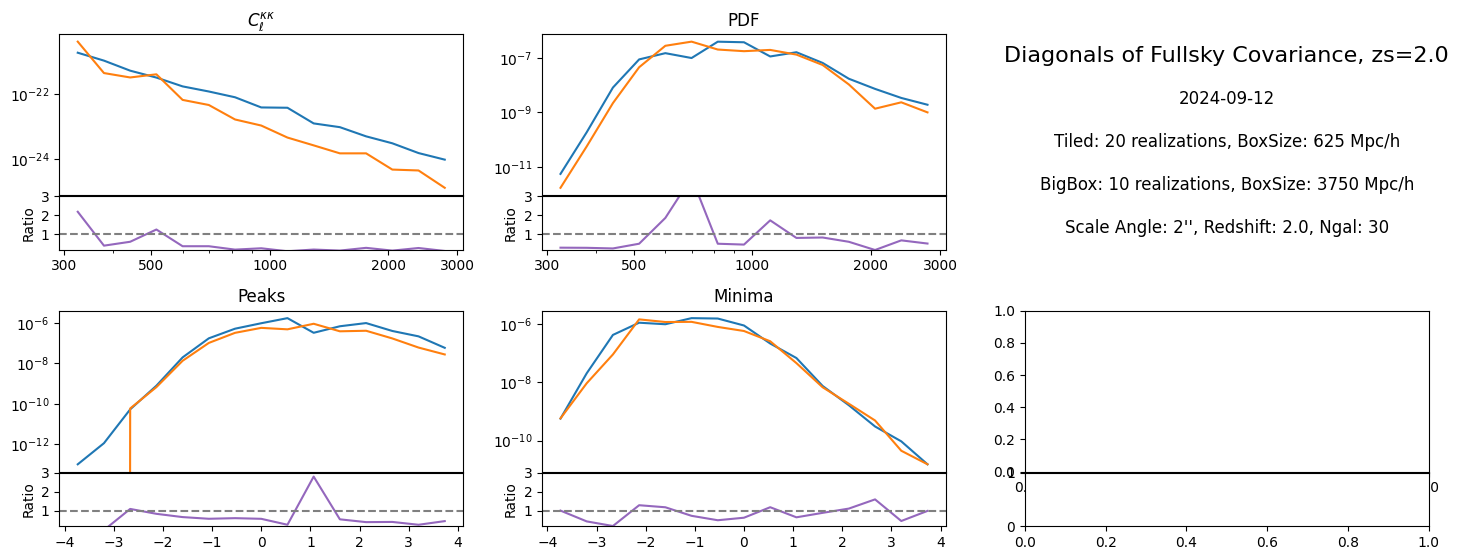

In [344]:
fname = f"{maindir}/img/fullsky/diagonal_{suffix}.png"
title = f"Diagonals of Fullsky Covariance, zs={zs}"
title_tiled = f"Tiled: {len(data_tiled)} realizations, BoxSize: {sboxsize} Mpc/h"
title_bigbox = f"BigBox: {len(data_bigbox)} realizations, BoxSize: {bboxsize} Mpc/h"
title_attrs = f"Scale Angle: {sl}"+r"''"+f", Redshift: {zs}"
if noiseless:
    title_attrs += ", Noiseless"
else:
    title_attrs += f", Ngal: {ngal}"
labels = [r'$C^{\kappa\kappa}_{\ell}$', 
          "PDF",
          "Peaks",
          "Minima"]

plot_stats(fname, title, title_tiled, title_bigbox, title_attrs ,ell, nu, diags_tiled, diags_bigbox, labels, ratio_range=[0.2, 3])

/var/tmp/pbs.282766.idark/ipykernel_9699/3468238889.py:51: RuntimeWarning: divide by zero encountered in true_divide
  ratio_axes[i].plot(nu, means_tiled[i*nbin:i*nbin+nbin]/means_bigbox[i*nbin:i*nbin+nbin], label=f"zs = {zs}", color=colors[j])
/var/tmp/pbs.282766.idark/ipykernel_9699/3468238889.py:51: RuntimeWarning: invalid value encountered in true_divide
  ratio_axes[i].plot(nu, means_tiled[i*nbin:i*nbin+nbin]/means_bigbox[i*nbin:i*nbin+nbin], label=f"zs = {zs}", color=colors[j])


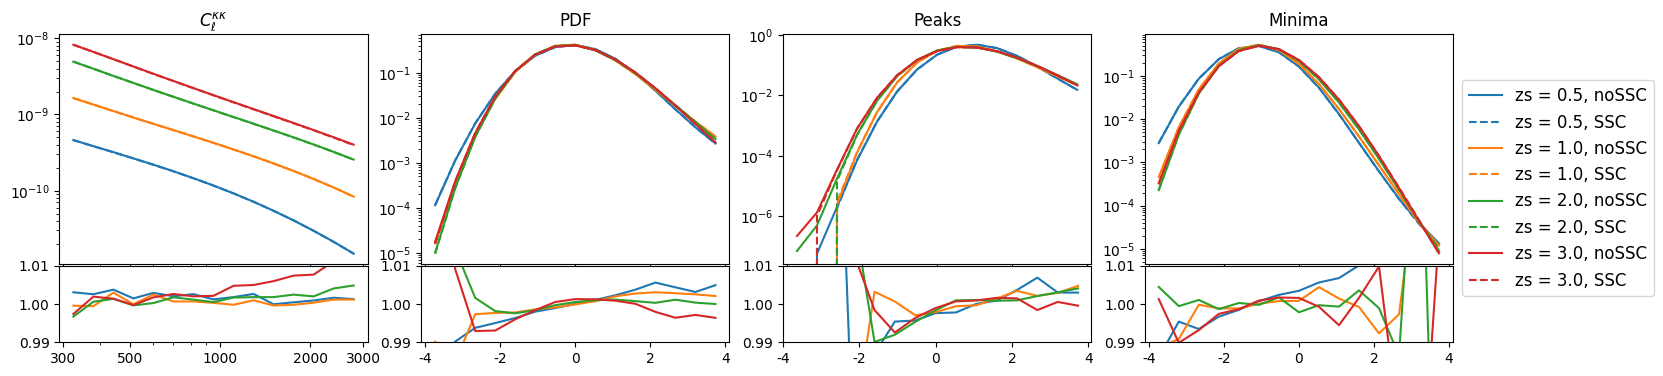

In [37]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(20, 4))

gs_master = GridSpec(nrows=1, ncols=5, width_ratios=[3, 3, 3, 3, 1], wspace=0.2)
gs_ell = [GridSpecFromSubplotSpec(2, 1, subplot_spec=gs_master[j], height_ratios=[3, 1], hspace=0.01) for j in range(4)]

axes = [fig.add_subplot(gs_ell[i][0]) for i in range(4)]
ratio_axes = [fig.add_subplot(gs_ell[i][1]) for i in range(4)]
legend_axes = fig.add_subplot(gs_master[4])

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
labels = [r'$C^{\kappa\kappa}_{\ell}$', 
          "PDF",
          "Peaks",
          "Minima"]

for j, zs in enumerate([0.5, 1.0, 2.0, 3.0]):
    suffix = gen_suffix(zs, scale_angle=sl, noiseless=noiseless, ngal=ngal)
    fullsky_tiled = sorted(glob(os.path.join(data_dir, "fullsky" ,"tiled", f'*_{suffix}.npy')))
    fullsky_bigbox = sorted(glob(os.path.join(data_dir,"fullsky" ,"bigbox", f'*_{suffix}.npy')))
    means_tiled, stds_tiled, diags_tiled, corr_tiled = stacking_analysis(fullsky_tiled)
    means_bigbox, stds_bigbox, diags_bigbox, corr_bigbox = stacking_analysis(fullsky_bigbox)


    for i in range(4):
        if i == 0:
            axes[i].plot(ell, means_tiled[i*nbin:i*nbin+nbin], label=f"zs = {zs}, noSSC", color=colors[j])
            axes[i].plot(ell, means_bigbox[i*nbin:i*nbin+nbin], label=f"zs = {zs}, SSC", color=colors[j], linestyle="--")
            axes[i].set_xscale('log')
            axes[i].set_yscale('log')
            axes[i].set_xticks([300, 500, 1000, 2000, 3000])
            axes[i].set_xticklabels(["300", "500", "1000", "2000", "3000"])
            axes[i].set_title(labels[i])
        else:
            axes[i].plot(nu, means_tiled[i*nbin:i*nbin+nbin], label=f"zs = {zs}, noSSC", color=colors[j])
            axes[i].plot(nu, means_bigbox[i*nbin:i*nbin+nbin], label=f"zs = {zs}, SSC", color=colors[j], linestyle="--")
            axes[i].set_yscale('log')
            axes[i].set_xticks([-4, -2, 0, 2, 4])
            axes[i].set_xticklabels(["-4", "-2", "0", "2", "4"])
            axes[i].set_title(labels[i])
        plt.setp(axes[i].get_xticklabels(), visible=False)

        if i == 0:
            ratio_axes[i].plot(ell, means_tiled[i*nbin:i*nbin+nbin]/means_bigbox[i*nbin:i*nbin+nbin], label=f"zs = {zs}", color=colors[j])
            ratio_axes[i].set_xscale('log')
            ratio_axes[i].set_xticks([300, 500, 1000, 2000, 3000])
            ratio_axes[i].set_xticklabels(["300", "500", "1000", "2000", "3000"])
            ratio_axes[i].set_ylim(0.99, 1.01)
        else:
            ratio_axes[i].plot(nu, means_tiled[i*nbin:i*nbin+nbin]/means_bigbox[i*nbin:i*nbin+nbin], label=f"zs = {zs}", color=colors[j])
            ratio_axes[i].set_xticks([-4, -2, 0, 2, 4])
            ratio_axes[i].set_xticklabels(["-4", "-2", "0", "2", "4"])
            ratio_axes[i].set_ylim(0.99, 1.01)

    legend_axes.legend(*axes[0].get_legend_handles_labels(), loc='center', fontsize=12)
    legend_axes.axis('off')

plt.show()

/var/tmp/pbs.282766.idark/ipykernel_9699/2254574599.py:50: RuntimeWarning: divide by zero encountered in true_divide
  ratio_axes[i].plot(nu, diags_tiled[i*nbin:i*nbin+nbin]/diags_bigbox[i*nbin:i*nbin+nbin], label=f"zs = {zs}", color=colors[j])
/var/tmp/pbs.282766.idark/ipykernel_9699/2254574599.py:50: RuntimeWarning: invalid value encountered in true_divide
  ratio_axes[i].plot(nu, diags_tiled[i*nbin:i*nbin+nbin]/diags_bigbox[i*nbin:i*nbin+nbin], label=f"zs = {zs}", color=colors[j])


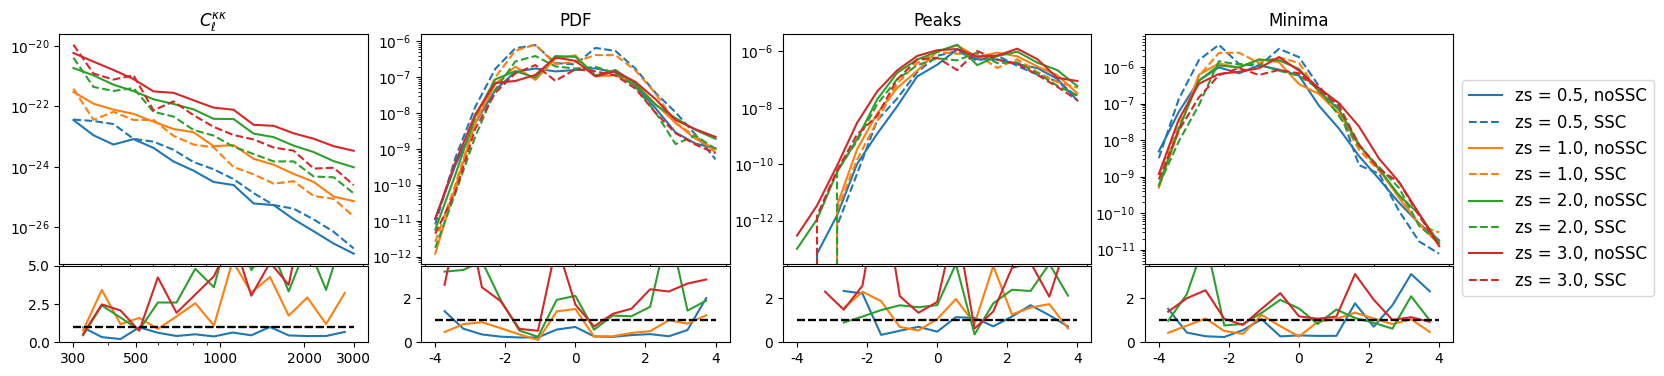

In [35]:
fig = plt.figure(figsize=(20, 4))

gs_master = GridSpec(nrows=1, ncols=5, width_ratios=[3, 3, 3, 3, 1], wspace=0.2)
gs_ell = [GridSpecFromSubplotSpec(2, 1, subplot_spec=gs_master[j], height_ratios=[3, 1], hspace=0.01) for j in range(4)]

axes = [fig.add_subplot(gs_ell[i][0]) for i in range(4)]
ratio_axes = [fig.add_subplot(gs_ell[i][1]) for i in range(4)]
legend_axes = fig.add_subplot(gs_master[4])

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
labels = [r'$C^{\kappa\kappa}_{\ell}$', 
          "PDF",
          "Peaks",
          "Minima"]

for j, zs in enumerate([0.5, 1.0, 2.0, 3.0]):
    suffix = gen_suffix(zs, scale_angle=sl, noiseless=noiseless, ngal=ngal)
    fullsky_tiled = sorted(glob(os.path.join(data_dir, "fullsky" ,"tiled", f'*_{suffix}.npy')))
    fullsky_bigbox = sorted(glob(os.path.join(data_dir,"fullsky" ,"bigbox", f'*_{suffix}.npy')))
    means_tiled, stds_tiled, diags_tiled, corr_tiled = stacking_analysis(fullsky_tiled)
    means_bigbox, stds_bigbox, diags_bigbox, corr_bigbox = stacking_analysis(fullsky_bigbox)


    for i in range(4):
        if i == 0:
            axes[i].plot(ell, diags_tiled[i*nbin:i*nbin+nbin], label=f"zs = {zs}, noSSC", color=colors[j])
            axes[i].plot(ell, diags_bigbox[i*nbin:i*nbin+nbin], label=f"zs = {zs}, SSC", color=colors[j], linestyle="--")
            axes[i].set_xscale('log')
            axes[i].set_yscale('log')
            axes[i].set_xticks([300, 500, 1000, 2000, 3000])
            axes[i].set_xticklabels(["300", "500", "1000", "2000", "3000"])
            axes[i].set_title(labels[i])
        else:
            axes[i].plot(nu, diags_tiled[i*nbin:i*nbin+nbin], label=f"zs = {zs}, noSSC", color=colors[j])
            axes[i].plot(nu, diags_bigbox[i*nbin:i*nbin+nbin], label=f"zs = {zs}, SSC", color=colors[j], linestyle="--")
            axes[i].set_yscale('log')
            axes[i].set_xticks([-4, -2, 0, 2, 4])
            axes[i].set_xticklabels(["-4", "-2", "0", "2", "4"])
            axes[i].set_title(labels[i])
        plt.setp(axes[i].get_xticklabels(), visible=False)

        if i == 0:
            ratio_axes[i].plot(ell, diags_tiled[i*nbin:i*nbin+nbin]/diags_bigbox[i*nbin:i*nbin+nbin], label=f"zs = {zs}", color=colors[j])
            ratio_axes[i].set_xscale('log')
            ratio_axes[i].set_xticks([300, 500, 1000, 2000, 3000])
            ratio_axes[i].set_xticklabels(["300", "500", "1000", "2000", "3000"])
            ratio_axes[i].set_ylim(0, 5)
            ratio_axes[i].hlines(1, 300, 3000, linestyle="--", color="black")
        else:
            ratio_axes[i].plot(nu, diags_tiled[i*nbin:i*nbin+nbin]/diags_bigbox[i*nbin:i*nbin+nbin], label=f"zs = {zs}", color=colors[j])
            ratio_axes[i].set_xticks([-4, -2, 0, 2, 4])
            ratio_axes[i].set_xticklabels(["-4", "-2", "0", "2", "4"])
            ratio_axes[i].set_ylim(0, 3.5)
            ratio_axes[i].hlines(1, -4, 4, linestyle="--", color="black")

    legend_axes.legend(*axes[0].get_legend_handles_labels(), loc='center', fontsize=12)
    legend_axes.axis('off')

plt.show()

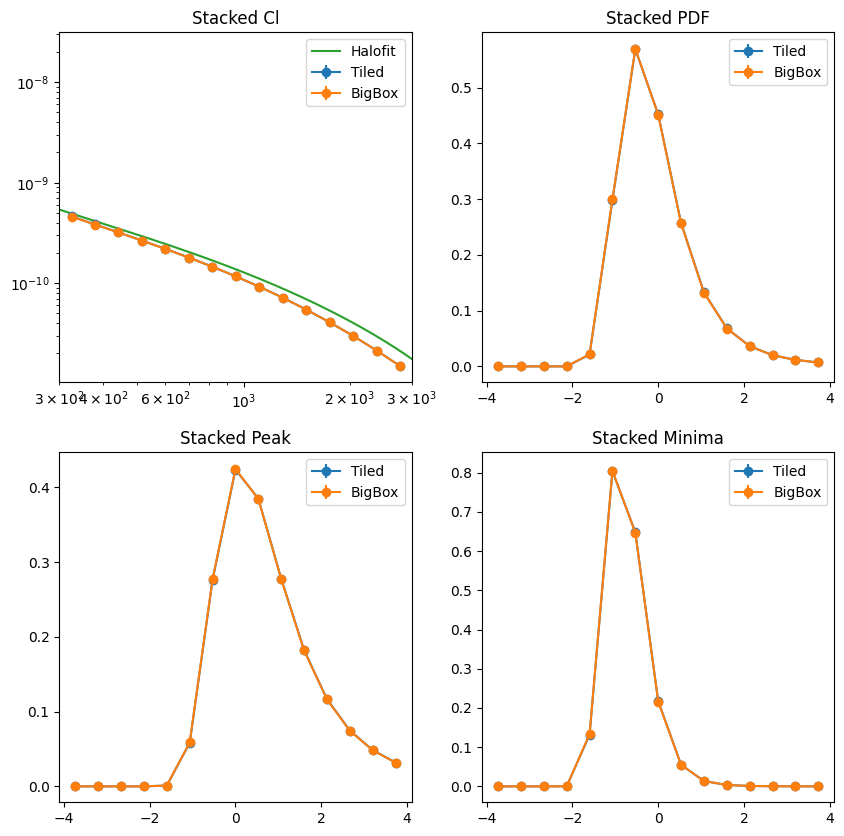

In [239]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Stacked Cl
ax[0, 0].errorbar(ell, means_tiled[:nbin], yerr=stds_tiled[:nbin], label="Tiled", fmt='-o')
ax[0, 0].errorbar(ell, means_bigbox[:nbin], yerr=stds_bigbox[:nbin], label="BigBox", fmt='-o')
ax[0, 0].plot(ell_hf, cl_hf, label="Halofit")
ax[0, 0].set_xscale("log")
ax[0, 0].set_yscale("log")
ax[0, 0].set_xlim(lmin, lmax)
ax[0, 0].set_title("Stacked Cl")
ax[0, 0].legend()

# Stacked PDF
ax[0, 1].errorbar(nu, means_tiled[nbin:2*nbin], yerr=stds_tiled[nbin:2*nbin], label="Tiled", fmt='-o')
ax[0, 1].errorbar(nu, means_bigbox[nbin:2*nbin], yerr=stds_bigbox[nbin:2*nbin], label="BigBox", fmt='-o')
ax[0, 1].set_title("Stacked PDF")
ax[0, 1].legend()

# Stacked Peak
ax[1, 0].errorbar(nu, means_tiled[2*nbin:3*nbin], yerr=stds_tiled[2*nbin:3*nbin], label="Tiled", fmt='-o')
ax[1, 0].errorbar(nu, means_bigbox[2*nbin:3*nbin], yerr=stds_bigbox[2*nbin:3*nbin], label="BigBox", fmt='-o')
ax[1, 0].set_title("Stacked Peak")
ax[1, 0].legend()

# Stacked Minima
ax[1, 1].errorbar(nu, means_tiled[3*nbin:], yerr=stds_tiled[3*nbin:], label="Tiled", fmt='-o')
ax[1, 1].errorbar(nu, means_bigbox[3*nbin:], yerr=stds_bigbox[3*nbin:], label="BigBox", fmt='-o')
ax[1, 1].set_title("Stacked Minima")
ax[1, 1].legend()

plt.show()


In [240]:
dl = l_edges[1:] - l_edges[:-1]
nl = (2 * ell + 1) * dl#(2*np.pi * ell * dl + np.pi* (dl**2))  * 4*np.pi / (4*np.pi**2)

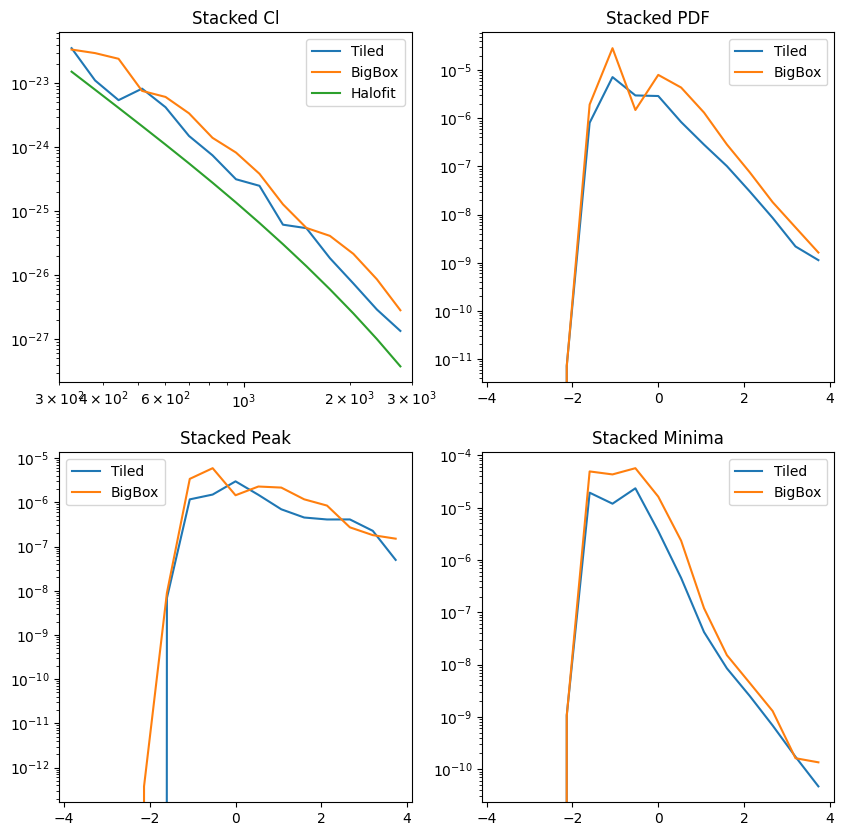

In [241]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Stacked Cl
ax[0, 0].plot(ell, diags_tiled[:nbin], label="Tiled")
ax[0, 0].plot(ell, diags_bigbox[:nbin], label="BigBox")
ax[0, 0].plot(ell, cl_dis**2 /nl * 2, label="Halofit")
ax[0, 0].set_xscale("log")
ax[0, 0].set_yscale("log")
ax[0, 0].set_xlim(lmin, lmax)
ax[0, 0].set_title("Stacked Cl")
ax[0, 0].legend()

# Stacked PDF
ax[0, 1].plot(nu, diags_tiled[nbin:2*nbin], label="Tiled")
ax[0, 1].plot(nu, diags_bigbox[nbin:2*nbin], label="BigBox")
ax[0, 1].set_yscale("log")
ax[0, 1].set_title("Stacked PDF")
ax[0, 1].legend()

# Stacked Peak
ax[1, 0].plot(nu, diags_tiled[2*nbin:3*nbin], label="Tiled")
ax[1, 0].plot(nu, diags_bigbox[2*nbin:3*nbin], label="BigBox")
ax[1, 0].set_yscale("log")
ax[1, 0].set_title("Stacked Peak")
ax[1, 0].legend()

# Stacked Minima
ax[1, 1].plot(nu, diags_tiled[3*nbin:], label="Tiled")
ax[1, 1].plot(nu, diags_bigbox[3*nbin:], label="BigBox")
ax[1, 1].set_yscale("log")
ax[1, 1].set_title("Stacked Minima")
ax[1, 1].legend()

plt.show()


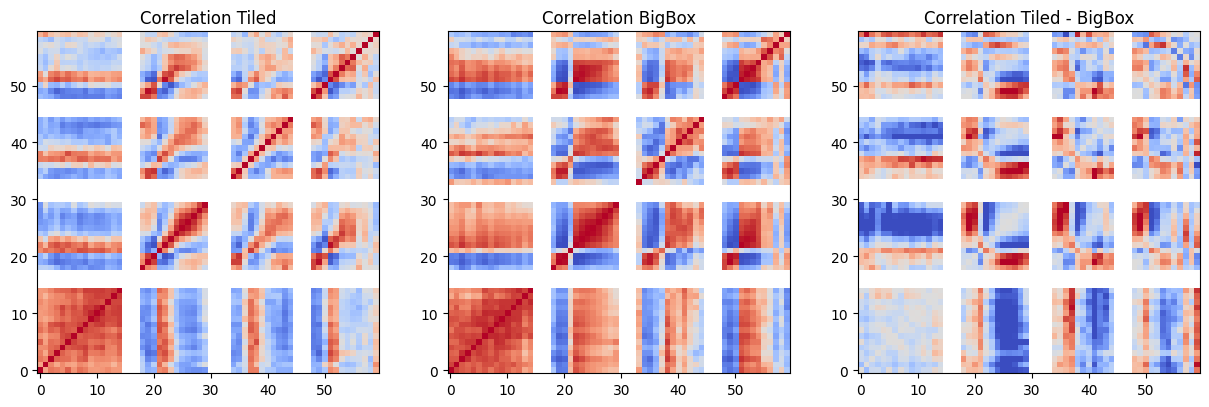

In [242]:
fig , ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(corr_tiled, cmap="coolwarm", vmin=-1, vmax=1)
ax[0].set_title("Correlation Tiled")
ax[0].invert_yaxis()

ax[1].imshow(corr_bigbox, cmap="coolwarm", vmin=-1, vmax=1)
ax[1].set_title("Correlation BigBox")
ax[1].invert_yaxis()

ax[2].imshow(corr_tiled- corr_bigbox, cmap="coolwarm", vmin=-1, vmax=1)
ax[2].set_title("Correlation Tiled - BigBox")
ax[2].invert_yaxis()

plt.show()

In [213]:
clkk_tiled = np.vstack([continuous_to_discrete(np.arange(0, lmax+1), clkki, l_edges) for clkki in clkk_tiled])
clkk_bigbox = np.vstack([continuous_to_discrete(np.arange(0, lmax+1), clkki, l_edges) for clkki in clkk_bigbox])

In [214]:
corrcl_tiled = np.corrcoef(clkk_tiled, rowvar=False)
corrcl_bigbox = np.corrcoef(clkk_bigbox, rowvar=False)

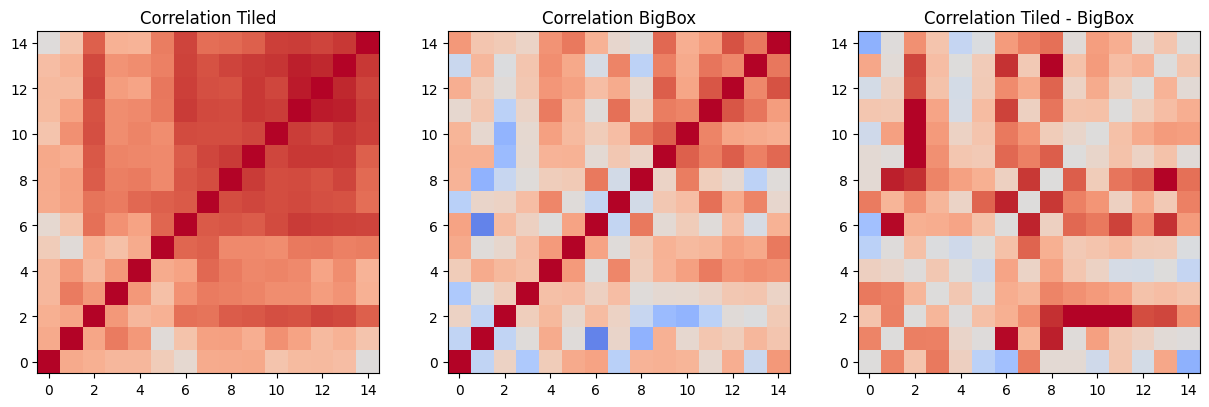

In [215]:
fig , ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(corrcl_tiled, cmap="coolwarm", vmin=-1, vmax=1)
ax[0].set_title("Correlation Tiled")
ax[0].invert_yaxis()

ax[1].imshow(corrcl_bigbox, cmap="coolwarm", vmin=-1, vmax=1)
ax[1].set_title("Correlation BigBox")
ax[1].invert_yaxis()

ax[2].imshow(corrcl_tiled- corrcl_bigbox, cmap="coolwarm", vmin=-1, vmax=1)
ax[2].set_title("Correlation Tiled - BigBox")
ax[2].invert_yaxis()

plt.show()

In [71]:
import pyccl as ccl

In [ ]:
kappas_tiled = [hp.read_map(kappa_file) for kappa_file in kappa_tiled]
kappas_bigbox = [hp.read_map(kappa_file) for kappa_file in kappa_bigbox]

In [ ]:
for kappa_path, kappa in zip(kappa_tiled, kappas_tiled):
    print(f"Processing {os.path.basename(kappa_path)}")
    cl = hp.anafast(kappa)
    fname = os.path.basename(kappa_path).split("_", 1)[1]
    print(f"Saving to {os.path.join(savedir, "tiled",'cl'+fname)}")
    hp.write_cl(os.path.join(savedir, "tiled","cl"+fname), cl)